### First things first , lets import all the required libraries 

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 39.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [4]:
from pmdarima.arima import auto_arima

In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ue21cs342aa2/sample_submission.csv
/kaggle/input/ue21cs342aa2/train.csv
/kaggle/input/ue21cs342aa2/test.csv


### Next lets import the test and train datasets provided

In [6]:
train = pd.read_csv("/kaggle/input/ue21cs342aa2/train.csv", index_col =0 )
test = pd.read_csv("/kaggle/input/ue21cs342aa2/test.csv",)

In [7]:
test

,id,Date,Open,Volume
0,0,2021-03-01,72.708331,205897600
1,1,2021-03-08,73.310886,214095600
2,2,2021-03-15,70.610119,151601700
3,3,2021-03-22,70.256017,193982500
4,4,2021-03-29,68.258324,220238400
...,...,...,...,...
95,95,2022-12-26,57.048622,224994700
96,96,2023-01-02,60.569661,176020500
97,97,2023-01-09,61.446777,181478600
98,98,2023-01-16,55.447711,162471700


### Since the given data is not in timeseries format , lets convert the train data to timeseries first 

In [8]:
train['Date'] = pd.to_datetime(train['Date'])
train.set_index('Date',inplace=True)
train

,Open,Close,Volume,Strategy
Date,,,,
2015-06-01,66.208486,75.609978,298506300,Hold
2015-06-08,64.116235,74.443331,227974800,Hold
2015-06-15,47.701942,71.140831,250670900,Buy
2015-06-22,54.754816,72.881344,223614300,Hold
2015-06-29,48.031899,66.284718,406814900,Buy
...,...,...,...,...
2021-01-25,81.284821,83.373498,117281600,Sell
2021-02-01,71.970249,85.294903,177655800,Sell
2021-02-08,71.784627,83.266453,146003500,Hold


### Next , we drop the Strategy Column (categorical data) from the train dataset as it helps us to build models with the numerical data. 

### We will first predict the Close prices and then predict the corresponding Strategy. 

In [9]:
train_data=train.drop(['Strategy'],axis=1)

In [10]:
test

,id,Date,Open,Volume
0,0,2021-03-01,72.708331,205897600
1,1,2021-03-08,73.310886,214095600
2,2,2021-03-15,70.610119,151601700
3,3,2021-03-22,70.256017,193982500
4,4,2021-03-29,68.258324,220238400
...,...,...,...,...
95,95,2022-12-26,57.048622,224994700
96,96,2023-01-02,60.569661,176020500
97,97,2023-01-09,61.446777,181478600
98,98,2023-01-16,55.447711,162471700


### Lets convert the test data also to timeseries format 

In [11]:
test['Date'] = pd.to_datetime(test['Date'])
test.set_index('Date',inplace=True)
test

,id,Open,Volume
Date,,,
2021-03-01,0,72.708331,205897600
2021-03-08,1,73.310886,214095600
2021-03-15,2,70.610119,151601700
2021-03-22,3,70.256017,193982500
2021-03-29,4,68.258324,220238400
...,...,...,...
2022-12-26,95,57.048622,224994700
2023-01-02,96,60.569661,176020500
2023-01-09,97,61.446777,181478600


### In order for to predict the Close price better , let us add create another feature . 
### The new feature we will be creating is Exponential Moving Average with respect to the Open Price
### The EMA places more weight on recent prices, which means that it reacts more quickly to price changes and trends. This responsiveness to recent data can be especially useful for short-term trading strategies and technical analysis in financial markets.

### Next we will create 3 new features with respect to Open price again - Open_Lag_1 , Open_Lag_2 , Open_Lag_3
### "Lags" refer to the number of past time periods or data points that are used to create lagged values of a variable
###  Lagged values are essentially delayed or shifted versions of the original variable, where the lag specifies how many time periods back you want to look.

### Let us visualise how the train data is distributed next

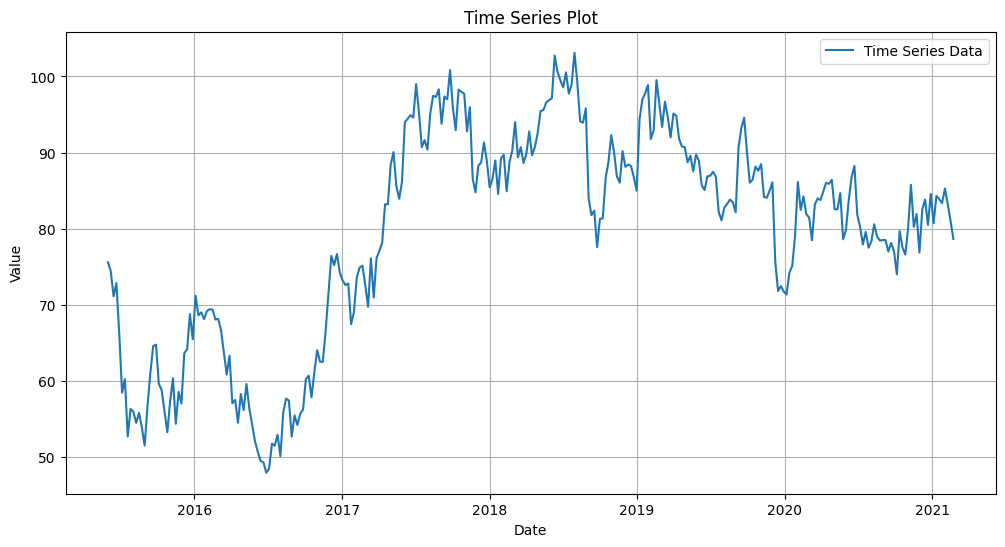

In [12]:
plt.figure(figsize=(12,6))
plt.plot(train.index, train['Close'], label='Time Series Data')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Time Series Plot')
plt.grid(True)
plt.legend()
plt.show()

## Now , Let us check if the data is stationary or not. 

### If the data is stationary , we can further build different kinds of models. 

### If the data is not stationary , we first have to convert the data into stationary form and then go on with building models.

## We will conduct a test called Augmented Dickey Fuller Test which will help us determine if the data is stationary or not.

### The Null Hypothesis in this case is H0: ψ = 0 implies the time series is non-stationary
### The Alternate Hypothesis in this case is HA: ψ < 0 (the time series is stationary)

In [13]:
t = sm.tsa.adfuller(train['Close'], autolag='AIC')
pd.Series(t[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations used'])

Test Statistic                  -1.808006
p-value                          0.376494
#Lags Used                       1.000000
Number of Observations used    298.000000
dtype: float64

### From the above ADF Test we can conclude that we fail to reject the NULL Hypothesis which implies the time series is non stationary because The Test Statistic value is equal to -1.8 The more negative this value is , the stronger is the evidence for stationarity of the data
### The p value for the test conducted is equal to 0.3 which is very high.Since the p-value is high, we don't have enough evidence to accept the alternative hypothesis.
### Thus we fail to reject the NULL Hypothesis implying the time series is Non Stationary

### To convert the non stationary data to stationary data , we differenttiate the data. First we will try a differentiation of the order of 1 and re conduct the ADF test.

In [14]:
train['differenced_values'] = train['Close'].diff(1)
train.dropna(inplace=True)

In [15]:
t = sm.tsa.adfuller(train['differenced_values'], autolag='AIC')
pd.Series(t[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations used'])

Test Statistic                 -19.615948
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations used    298.000000
dtype: float64

### From the above ADF test we can see that the test statictic is much higher than the previous value.
### The p value is also less than 0.05 which means single order differencing worked here and the data is stationary now.

### Therefore d = 1

### Next let us use auto-correlation plots and determine the required values of p and q for building AR , MA, ARIMA , ARIMAX , SARIMA , SARIMAX models

ACF plot


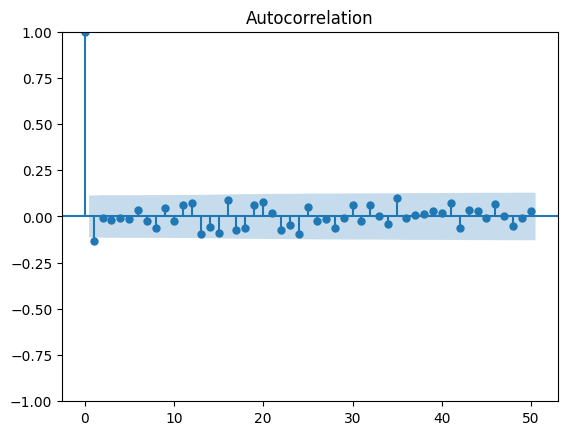

In [16]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
print("ACF plot")
plot_acf(train.differenced_values,lags=50)
plt.show()

#### From the above graph , we can interpret that the q value is equal to 1 since spikes decay to 0 after a lag value of 1 .

PACF plot


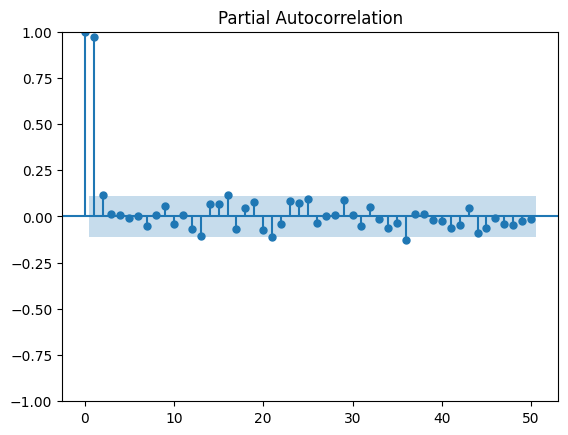

In [17]:
plot_pacf(train.Close,lags=50,method='ywm')
print("PACF plot")
plt.show()

#### From the above graph , we can interpret that the p value is equal to 2 since spikes decay to 0 after a lag value of 2 .

### The above p and q and d values which we detemined might not be the optimal values. Therefore we make use of auto arima model which helps us determine the optimal p,d,q values from a range of values. We select the p,d,q values with the lowest AIC value.
### The Akaike Information Criterion (AIC) is a statistical measure used for model selection and comparison in the context of regression analysis and time series modeling. AIC quantifies the trade-off between a model's goodness of fit and its complexity, penalizing models with too many parameters. It is employed to choose the best-fitting model among a set of candidate models. The model with the lowest AIC value is typically preferred because it represents a good balance between explaining the data and avoiding overfitting.

In [18]:
train_data

,Open,Close,Volume
Date,,,
2015-06-01,66.208486,75.609978,298506300
2015-06-08,64.116235,74.443331,227974800
2015-06-15,47.701942,71.140831,250670900
2015-06-22,54.754816,72.881344,223614300
2015-06-29,48.031899,66.284718,406814900
...,...,...,...
2021-01-25,81.284821,83.373498,117281600
2021-02-01,71.970249,85.294903,177655800
2021-02-08,71.784627,83.266453,146003500


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1559.459, Time=0.14 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1556.675, Time=0.40 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1556.085, Time=0.42 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1557.462, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=1556.098, Time=0.08 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=1550.223, Time=0.83 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=1556.545, Time=0.37 sec
 ARIMA(0,1,1)(2,0,1)[12] intercept   : AIC=1551.505, Time=3.00 sec
 ARIMA(0,1,1)(1,0,2)[12] intercept   : AIC=1551.466, Time=1.95 sec
 ARIMA(0,1,1)(0,0,2)[12] intercept   : AIC=1553.272, Time=1.27 sec
 ARIMA(0,1,1)(2,0,0)[12] intercept   : AIC=1554.511, Time=1.21 sec
 ARIMA(0,1,1)(2,0,2)[12] intercept   : AIC=inf, Time=6.38 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=1554.161, Time=0.71 sec
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=1552.202, Time=1.24 sec
 ARIMA(0,1,2)(1,0,1)[12]

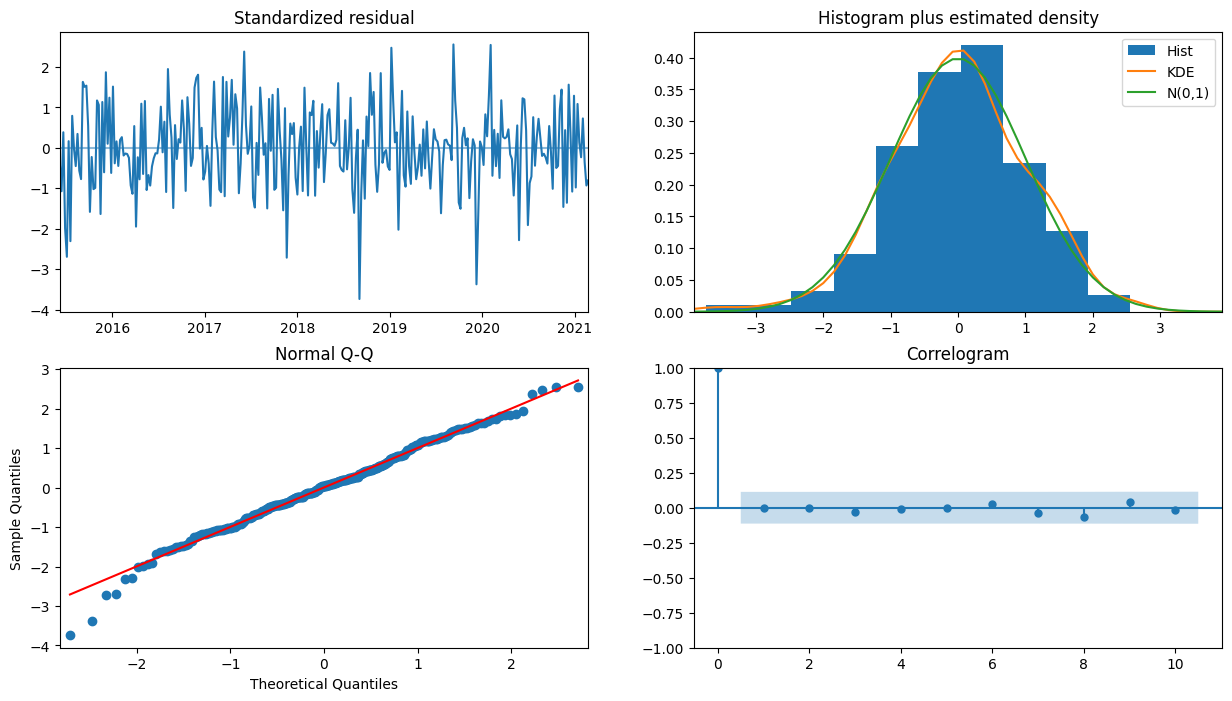

In [19]:
model_autoARIMA = auto_arima(train_data['Close'], start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=5, max_q=5, # maximum p and q
                      m=12,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=True,   # No Seasonality
                      start_P=0, 
                      D=None, 
                      start_Q=0,
                      max_P=5,max_D=5, max_Q=5, # maximum p and q
                      
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True,information_criteria='AIC')
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

### Let us take a look at the summary of the model which gives us the optimal results 

In [20]:
model_autoARIMA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  300
Model:             SARIMAX(0, 1, 1)x(1, 0, 1, 12)   Log Likelihood                -770.114
Date:                            Wed, 01 Nov 2023   AIC                           1548.229
Time:                                    18:01:15   BIC                           1563.031
Sample:                                06-01-2015   HQIC                          1554.153
                                     - 02-22-2021                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1426      0.058     -2.440      0.015      -0.257      -0.028
ar.S.L12      -0.7068      0.149     -4.756      0.000      -0.998      -0.416
ma.S.L12       0.8481      0.118      7.171      0.000       0.616       1.080
sigma2        10.0543      0.737     13.639      0.000       8.609      11.499
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 6.40
Prob(Q):                              0.99   Prob(JB):                         0.04
Heteroskedasticity (H):               0.82   Skew:                            -0.23
Prob(H) (two-sided):                  0.32   Kurtosis:                         3.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### We will be making use of the Ljung Box Test to evaluate our SARIMAX Model
### The Ljung-Box test is a statistical test used to assess the presence of autocorrelation in a time series.
### It is used to test the null hypothesis that there is no autocorrelation in the residuals at a specified lag or set of lags.
### From the above summary of the SARIMAX model , we can see that the Ljung Box Test score is quite low

### Next let us build a SARIMAX model on the whole train data taking into account all of the exogeneous variables to predict the Close price 

In [21]:
import warnings

endog = train['Close']
exog = sm.add_constant(train[['Open', 'Volume']])
mod = sm.tsa.statespace.SARIMAX(endog=endog, exog=exog, order=(0,1,1),seasonal_order=(1,0,1,12))
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    model_fit = mod.fit()

model_fit.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.57497D+00    |proj g|=  2.45819D+09


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7      1     21      1     0     0   2.458D+09   2.575D+00
  F =   2.5749667391070017     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              Close   No. Observations:                  299
Model:             SARIMAX(0, 1, 1)x(1, 0, 1, 12)   Log Likelihood                -769.915
Date:                            Wed, 01 Nov 2023   AIC                           1553.830
Time:                                    18:01:17   BIC                           1579.710
Sample:                                06-08-2015   HQIC                          1564.189
                                     - 02-22-2021                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const               0   5.05e-10          0      1.000   -9.89e-10    9.89e-10
Open          -0.0908      0.049     -1.857      0.063      -0.187       0.005
Volume     -2.563e-09   1.66e-09     -1.542      0.123   -5.82e-09    6.94e-10
ma.L1         -0.1281      0.008    -15.199      0.000      -0.145      -0.112
ar.S.L12      -0.0396      0.028     -1.392      0.164      -0.095       0.016
ma.S.L12       0.1457      0.029      5.034      0.000       0.089       0.202
sigma2        10.0325      0.000    2.1e+04      0.000      10.032      10.033
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 3.06
Prob(Q):                              0.92   Prob(JB):                         0.22
Heteroskedasticity (H):               0.78   Skew:                            -0.18
Prob(H) (two-sided):                  0.22   Kurtosis:                         3.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.4e+25. Standard errors may be unstable.
"""

### We can see that the value of the Ljung Box test is 0.38 which tells us that there is no strong evidence of significant autocorrelation in the residuals.

### A small test statistic, such as 0.38, indicates that the observed autocorrelation in the residuals is not significantly different from what would be expected under the null hypothesis of no autocorrelation. Therefore, we have strong evidence to reject the null hypothesis, suggesting that there is no significant autocorrelation in the residuals at the tested lags.

### Next we divide the train data into train and test(validation) so that we can asses the performance of the model

In [22]:
size=int(len(train_data)*0.8)
Xtrain,Xtest=train_data[0:size],train_data[size:]
Xtrain.head()

,Open,Close,Volume
Date,,,
2015-06-01,66.208486,75.609978,298506300
2015-06-08,64.116235,74.443331,227974800
2015-06-15,47.701942,71.140831,250670900
2015-06-22,54.754816,72.881344,223614300
2015-06-29,48.031899,66.284718,406814900


### Next we build the SARIMAX model based on the sub training set that has been created from the original training set. 

In [23]:
import warnings

endog = train['Close']
exog = sm.add_constant(train[['Open', 'Volume']])
mod = sm.tsa.statespace.SARIMAX(train_data["Close"], order=(0,1,1),seasonal_order=(1,0,1,12))
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    model_fit = mod.fit()

model_fit.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.57989D+00    |proj g|=  1.65970D-02


 This problem is unconstrained.



At iterate    5    f=  2.57071D+00    |proj g|=  3.30962D-02

At iterate   10    f=  2.56705D+00    |proj g|=  6.97234D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     19      1     0     0   2.897D-06   2.567D+00
  F =   2.5670482925869282     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              Close   No. Observations:                  300
Model:             SARIMAX(0, 1, 1)x(1, 0, 1, 12)   Log Likelihood                -770.114
Date:                            Wed, 01 Nov 2023   AIC                           1548.229
Time:                                    18:01:18   BIC                           1563.031
Sample:                                06-01-2015   HQIC                          1554.153
                                     - 02-22-2021                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1426      0.058     -2.440      0.015      -0.257      -0.028
ar.S.L12      -0.7068      0.149     -4.756      0.000      -0.998      -0.416
ma.S.L12       0.8481      0.118      7.171      0.000       0.616       1.080
sigma2        10.0543      0.737     13.639      0.000       8.609      11.499
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 6.40
Prob(Q):                              0.99   Prob(JB):                         0.04
Heteroskedasticity (H):               0.82   Skew:                            -0.23
Prob(H) (two-sided):                  0.32   Kurtosis:                         3.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### We can see that the value of the Ljung Box test is 0.09 which tells us that there is no strong evidence of significant autocorrelation in the residuals.
### It suggests that the residuals appear to be reasonably close to being uncorrelated.
### Therefore the model's predictions do not exhibit strong systematic patterns of errors.

### Let us take a look at the distribution of the residuals and the residuals in the form of Q-Q Plot and the auto-correlation plot

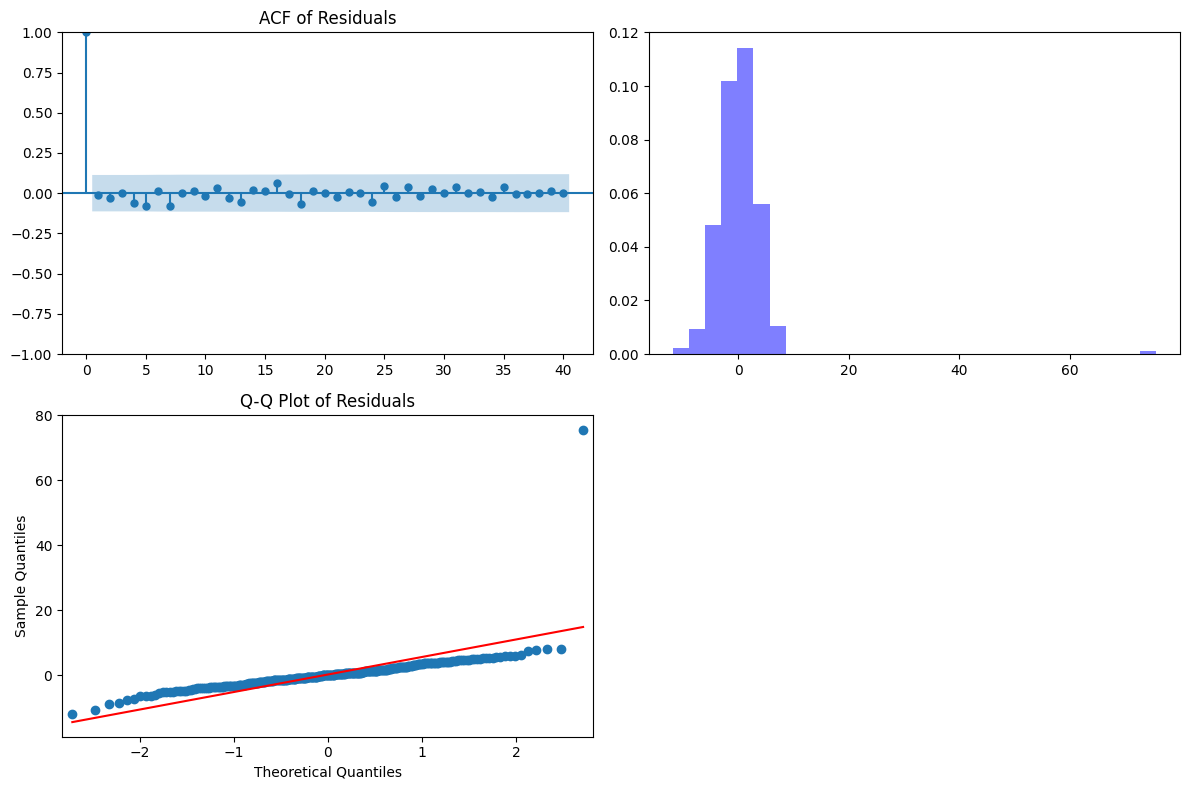

In [24]:
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Assuming you have a fitted SARIMAX model named 'sarimax_model'
# And 'Xtest' is your test data
# You should have the residuals of the model already obtained

# Calculate the residuals
residuals = model_fit.resid

# Create diagnostic plots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Residuals plot
sm.graphics.tsa.plot_acf(residuals, lags=40, ax=axes[0, 0])
axes[0, 0].set_title("ACF of Residuals")

# Histogram of residuals
axes[0, 1].hist(residuals, bins=30, density=True, alpha=0.5, color='b')
sm.qqplot(residuals, line='s', ax=axes[1, 0])
axes[1, 0].set_title("Q-Q Plot of Residuals")
axes[1, 1].set_visible(False)

plt.tight_layout()
plt.show()

### We can see from the above histogram that the residuals follow normal distribution. 
### This is corroborated from the Q-Q Plot also.
### There seems to be a few outliers in the data.

### Let us move on to predicting the Close prices with the SARIMAX model we built earlier with respect to the test(validation data - train data split into train and validation) data.

In [25]:
predict_sari = pd.DataFrame(model_fit.predict(start=len(Xtrain), end=len(train_data)))


predict_sari.columns=['Predictions']
predict_sari.tail()

,Predictions
2021-02-01,82.987740
2021-02-08,84.387691
2021-02-15,83.975864
2021-02-22,81.216030
2021-03-01,79.745578


### Now let us merge the test data and the predicted values

In [26]:
import pandas as pd
merge_data=pd.concat((predict_sari,Xtest),axis=1)
merge_data.tail()



,Predictions,Open,Close,Volume
2021-02-01,82.987740,71.970249,85.294903,177655800.0
2021-02-08,84.387691,71.784627,83.266453,146003500.0
2021-02-15,83.975864,69.372333,81.026827,167762500.0
2021-02-22,81.216030,69.618620,78.672007,332979200.0
2021-03-01,79.745578,NaN,NaN,NaN


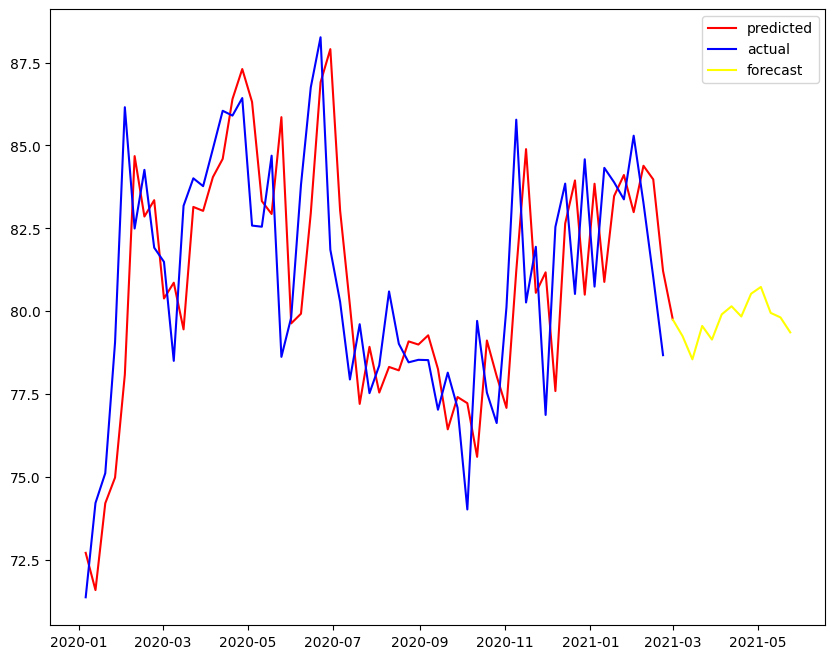

In [27]:
plt.figure(figsize=(10,8))
plt.plot(merge_data.index,merge_data['Predictions'],color='red',label='predicted')
plt.plot(merge_data.index,merge_data['Close'], color = 'blue', label ='actual')
plt.plot(pd.DataFrame(model_fit.predict(start=len(train_data['Close']),end=len(train_data['Close'])+12)),color='yellow',label='forecast')
plt.legend()

### Let us calculate the SMAPE score of our model. 

In [28]:
# SMAPE Calculation
y_pred = predict_sari.values
y_true = Xtest['Close'].values
smape = 100 * np.mean(np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true)))

print(f"SMAPE: {smape:.2f}%")

SMAPE: 2.51%


### The SMAPE score is quite less which tells us that the model we built is good 

In [29]:
test_data = pd.read_csv("/kaggle/input/ue21cs342aa2/test.csv")

In [30]:
test_data['Date'] = pd.to_datetime(test_data['Date'])
test_data.set_index('Date',inplace=True)
test_data

,id,Open,Volume
Date,,,
2021-03-01,0,72.708331,205897600
2021-03-08,1,73.310886,214095600
2021-03-15,2,70.610119,151601700
2021-03-22,3,70.256017,193982500
2021-03-29,4,68.258324,220238400
...,...,...,...
2022-12-26,95,57.048622,224994700
2023-01-02,96,60.569661,176020500
2023-01-09,97,61.446777,181478600


In [31]:
# Assuming you have already trained your SARIMAX model (res2)
# Load the test dataset
#dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
#test_data = pd.read_csv("/kaggle/input/ue21cs342aa2/test.csv", index_col='Date', parse_dates=['Date'], date_parser=dateparse).fillna(0)
test_data = test.rename_axis(None)

# Make predictions on the test data
predict_sari = model_fit.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1)

# Create a DataFrame for the predictions
predictions_df = pd.DataFrame({'Close': predict_sari})

In [32]:
test_data=pd.concat([test_data,predictions_df],axis=1)
test_data

,id,Open,Volume,Close
2021-03-01,0,72.708331,205897600,79.745578
2021-03-08,1,73.310886,214095600,79.244268
2021-03-15,2,70.610119,151601700,78.546732
2021-03-22,3,70.256017,193982500,79.553506
2021-03-29,4,68.258324,220238400,79.142505
...,...,...,...,...
2022-12-26,95,57.048622,224994700,79.494042
2023-01-02,96,60.569661,176020500,79.533800
2023-01-09,97,61.446777,181478600,79.502580
2023-01-16,98,55.447711,162471700,79.459139


In [33]:
train_data = pd.read_csv("/kaggle/input/ue21cs342aa2/train.csv",)

In [34]:
train_data['Date'] = pd.to_datetime(train_data['Date'])
train_data.set_index('Date',inplace=True)
train_data

,id,Open,Close,Volume,Strategy
Date,,,,,
2015-06-01,0,66.208486,75.609978,298506300,Hold
2015-06-08,1,64.116235,74.443331,227974800,Hold
2015-06-15,2,47.701942,71.140831,250670900,Buy
2015-06-22,3,54.754816,72.881344,223614300,Hold
2015-06-29,4,48.031899,66.284718,406814900,Buy
...,...,...,...,...,...
2021-01-25,295,81.284821,83.373498,117281600,Sell
2021-02-01,296,71.970249,85.294903,177655800,Sell
2021-02-08,297,71.784627,83.266453,146003500,Hold


In [35]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC  # Added for SVM
import xgboost as xgb  # Added for XGBoost
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt


# Feature selection - You can choose relevant features from the dataset
features = ['Open', 'Close', 'Volume']

# Define the target variable (Strategy)
target = 'Strategy'

# Split the data into training and testing sets
X = train_data[features]
y = train_data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_predictions)
print(f"Random Forest Accuracy: {rf_accuracy}")

# Create and train the K-Nearest Neighbors model
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)
knn_predictions = knn_model.predict(X_test)
knn_accuracy = accuracy_score(y_test, knn_predictions)
print(f"K-Nearest Neighbors Accuracy: {knn_accuracy}")

# Create and train the Logistic Regression model
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)
lr_predictions = lr_model.predict(X_test)
lr_accuracy = accuracy_score(y_test, lr_predictions)
print(f"Logistic Regression Accuracy: {lr_accuracy}")

# Create and train the Decision Tree model
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)
dt_predictions = dt_model.predict(X_test)
dt_accuracy = accuracy_score(y_test, dt_predictions)
print(f"Decision Tree Accuracy: {dt_accuracy}")



# Use the trained models to predict strategies for the test data
test_features = test_data[features]

test_predictions_rf = rf_model.predict(test_features)
test_predictions_knn = knn_model.predict(test_features)
test_predictions_lr = lr_model.predict(test_features)
test_predictions_dt = dt_model.predict(test_features)


# Save the predictions to a CSV file or take further action as needed
test_data['Strategy_RF'] = test_predictions_rf
test_data['Strategy_KNN'] = test_predictions_knn
test_data['Strategy_LR'] = test_predictions_lr
test_data['Strategy_DT'] = test_predictions_dt

test_data.to_csv('test_predictions.csv', index=False)




Random Forest Accuracy: 0.48333333333333334
K-Nearest Neighbors Accuracy: 0.4
Logistic Regression Accuracy: 0.4
Decision Tree Accuracy: 0.55


In [36]:
test_data

,id,Open,Volume,Close,Strategy_RF,Strategy_KNN,Strategy_LR,Strategy_DT
2021-03-01,0,72.708331,205897600,79.745578,Buy,Hold,Hold,Sell
2021-03-08,1,73.310886,214095600,79.244268,Buy,Sell,Hold,Sell
2021-03-15,2,70.610119,151601700,78.546732,Buy,Sell,Hold,Buy
2021-03-22,3,70.256017,193982500,79.553506,Hold,Buy,Hold,Hold
2021-03-29,4,68.258324,220238400,79.142505,Sell,Hold,Hold,Hold
...,...,...,...,...,...,...,...,...
2022-12-26,95,57.048622,224994700,79.494042,Hold,Buy,Hold,Hold
2023-01-02,96,60.569661,176020500,79.533800,Hold,Sell,Hold,Hold
2023-01-09,97,61.446777,181478600,79.502580,Sell,Hold,Hold,Hold
2023-01-16,98,55.447711,162471700,79.459139,Hold,Hold,Hold,Hold


In [37]:
test_data.drop(['Strategy_RF', 'Strategy_KNN', 'Strategy_LR'], axis=1, inplace=True)
test_data

,id,Open,Volume,Close,Strategy_DT
2021-03-01,0,72.708331,205897600,79.745578,Sell
2021-03-08,1,73.310886,214095600,79.244268,Sell
2021-03-15,2,70.610119,151601700,78.546732,Buy
2021-03-22,3,70.256017,193982500,79.553506,Hold
2021-03-29,4,68.258324,220238400,79.142505,Hold
...,...,...,...,...,...
2022-12-26,95,57.048622,224994700,79.494042,Hold
2023-01-02,96,60.569661,176020500,79.533800,Hold
2023-01-09,97,61.446777,181478600,79.502580,Hold
2023-01-16,98,55.447711,162471700,79.459139,Hold


In [38]:
test_data.rename(columns={'Strategy_DT': 'Strategy'}, inplace=True)
test_data

,id,Open,Volume,Close,Strategy
2021-03-01,0,72.708331,205897600,79.745578,Sell
2021-03-08,1,73.310886,214095600,79.244268,Sell
2021-03-15,2,70.610119,151601700,78.546732,Buy
2021-03-22,3,70.256017,193982500,79.553506,Hold
2021-03-29,4,68.258324,220238400,79.142505,Hold
...,...,...,...,...,...
2022-12-26,95,57.048622,224994700,79.494042,Hold
2023-01-02,96,60.569661,176020500,79.533800,Hold
2023-01-09,97,61.446777,181478600,79.502580,Hold
2023-01-16,98,55.447711,162471700,79.459139,Hold


In [39]:

test_data.reset_index(inplace=True)
test_data.rename(columns={'index': 'Date'}, inplace=True)
test_data.set_index('id', inplace=True)
test_data

,Date,Open,Volume,Close,Strategy
id,,,,,
0,2021-03-01,72.708331,205897600,79.745578,Sell
1,2021-03-08,73.310886,214095600,79.244268,Sell
2,2021-03-15,70.610119,151601700,78.546732,Buy
3,2021-03-22,70.256017,193982500,79.553506,Hold
4,2021-03-29,68.258324,220238400,79.142505,Hold
...,...,...,...,...,...
95,2022-12-26,57.048622,224994700,79.494042,Hold
96,2023-01-02,60.569661,176020500,79.533800,Hold
97,2023-01-09,61.446777,181478600,79.502580,Hold


In [40]:
#test_data.to_csv('test_data.csv')

In [41]:
submission = pd.DataFrame()
submission["Date"] = test_data["Date"]

In [42]:
submission

,Date
id,
0,2021-03-01
1,2021-03-08
2,2021-03-15
3,2021-03-22
4,2021-03-29
...,...
95,2022-12-26
96,2023-01-02
97,2023-01-09


In [43]:
#sample_submission = pd.read_csv('test_data.csv', index_col = 0)

In [44]:
#sample_submission

In [45]:
submission['Close']=test_data['Close']


In [46]:
submission['Close']

id
0     79.745578
1     79.244268
2     78.546732
3     79.553506
4     79.142505
        ...    
95    79.494042
96    79.533800
97    79.502580
98    79.459139
99    79.521838
Name: Close, Length: 100, dtype: float64

In [47]:
submission["Strategy"] = test_data["Strategy"]

In [48]:
submission["Strategy"]

id
0     Sell
1     Sell
2      Buy
3     Hold
4     Hold
      ... 
95    Hold
96    Hold
97    Hold
98    Hold
99    Hold
Name: Strategy, Length: 100, dtype: object

In [49]:
submission.head()

,Date,Close,Strategy
id,,,
0,2021-03-01,79.745578,Sell
1,2021-03-08,79.244268,Sell
2,2021-03-15,78.546732,Buy
3,2021-03-22,79.553506,Hold
4,2021-03-29,79.142505,Hold


In [50]:
submission.to_csv('submission.csv', index=True)